<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Аналитика" data-toc-modified-id="Аналитика-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Аналитика</a></span><ul class="toc-item"><li><span><a href="#Вывод:" data-toc-modified-id="Вывод:-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод:</a></span></li></ul></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Спрос на рейсы авиакомпании

Вы аналитик российской авиакомпании F9, выполняющей внутренние пассажирские перевозки. Важно понять предпочтения пользователей, покупающих билеты на разные направления.

Вам предстоит изучить базу данных и проанализировать спрос пассажиров на рейсы в города, где проходят крупнейшие культурные фестивали.

У вас есть файлы с результатами запросов из предыдущих заданий.

**query_1.csv** — результат первого запроса. В нём содержится такая информация:

- *model* — **модель самолета;
- *flights_amount* — количество рейсов для каждой модели самолетов *model* в сентябре 2018 года.

**query_3.csv** — результат третьего запроса. В нём содержится такая информация:

- *city* — город;
- *average_flights* — среднее количество рейсов, прибывающих в город (*city*) за день в сентябре 2018 года.

 Для этих двух наборов данных нужно:

- импортировать файлы;
- изучить данные в них;
- проверить типы данных на корректность;
- выбрать топ-10 городов по количеству рейсов;
- построить графики: модели самолётов и количество рейсов, города и количество рейсов, топ-10 городов и количество рейсов;
- сделать выводы по каждому из графиков, пояснить результат.


## Аналитика

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
!pip install pyspark_dist_explore
import pyspark_dist_explore as pde
import seaborn as sns

Defaulting to user installation because normal site-packages is not writeable


In [2]:
APP_NAME = 'sampleApp'
spark = SparkSession.builder.appName(APP_NAME).config('spark.ui.showConsoleProgress', 'false').getOrCreate() 
data_model = spark.read.load('/datasets/query_1.csv', format='csv', header='true', inferSchema='true') 
data_city = spark.read.load('/datasets/query_3.csv', format='csv', header='true', inferSchema='true') 

In [3]:
def data_analys(data):
    print("Количество строк:", data.count())
    print(data)
    print(data.show(5))
    print(data.describe().show())
    print()
    
data_analys(data_model)
data_analys(data_city)

Количество строк: 8
DataFrame[model: string, flights_amount: int]
+---------------+--------------+
|          model|flights_amount|
+---------------+--------------+
|Airbus A319-100|           607|
|Airbus A321-200|           960|
| Boeing 737-300|           630|
| Boeing 767-300|           600|
| Boeing 777-300|           300|
+---------------+--------------+
only showing top 5 rows

None
+-------+-------------------+------------------+
|summary|              model|    flights_amount|
+-------+-------------------+------------------+
|  count|                  8|                 8|
|   mean|               null|          2035.625|
| stddev|               null|1965.2039470679445|
|    min|    Airbus A319-100|               300|
|    max|Sukhoi SuperJet-100|              4557|
+-------+-------------------+------------------+

None

Количество строк: 101
DataFrame[city: string, average_flights: double]
+-----------+------------------+
|       city|   average_flights|
+-----------+---------

+---------------+------------------+
|           city|   average_flights|
+---------------+------------------+
|         Москва| 129.7741935483871|
|Санкт-Петербург|31.161290322580644|
|    Новосибирск|17.322580645161292|
|     Красноярск|11.580645161290322|
|   Екатеринбург| 11.32258064516129|
| Ростов-на-Дону|10.193548387096774|
|          Пермь|10.129032258064516|
|         Брянск|              10.0|
|           Сочи| 9.612903225806452|
|      Ульяновск| 9.580645161290322|
+---------------+------------------+

None


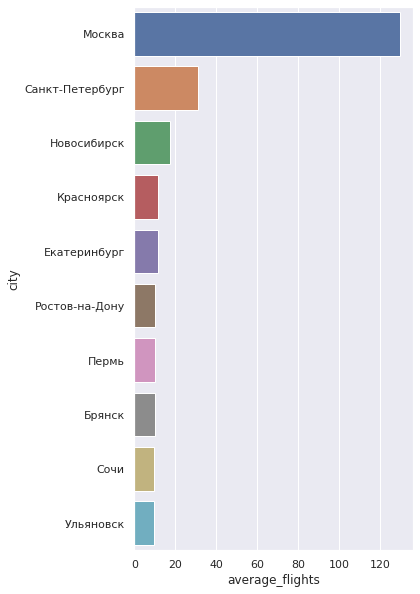

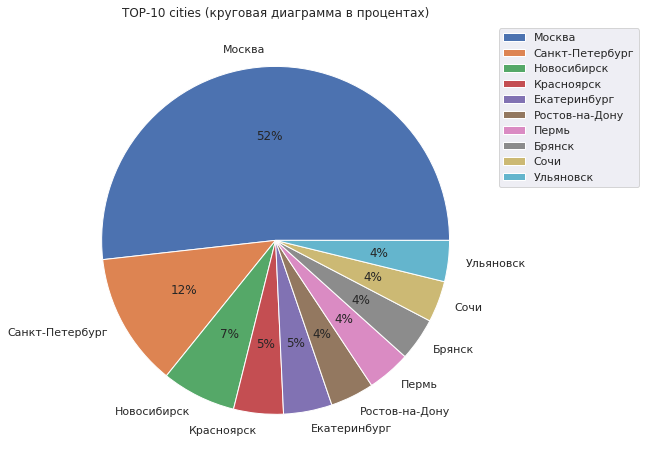

In [4]:
#топ-10 городов

data_city.registerTempTable("data_city")
print(spark.sql('SELECT * FROM data_city ORDER BY average_flights DESC LIMIT 10').show())

top_10 = spark.sql('SELECT * FROM data_city ORDER BY average_flights DESC LIMIT 10')

"""fig, ax = plt.subplots()
fig.set_size_inches(12, 4)
pde.hist(ax, top_10.select('average_flights'), bins = 10)
ax.set_title('TOP-10 cities (средствами pyspark)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()"""

top_10_pd = top_10.toPandas()
sns.set(rc={'figure.figsize':(5,10)})
sns.barplot(y=top_10_pd['city'], x = top_10_pd['average_flights'])
plt.show()

top_10_pd = top_10_pd.set_index('city')
top_10_pd.plot(kind='pie', subplots=True, figsize=(8, 8), autopct='%1.f%%')
plt.title("TOP-10 cities (круговая диаграмма в процентах)")
plt.ylabel("")
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()

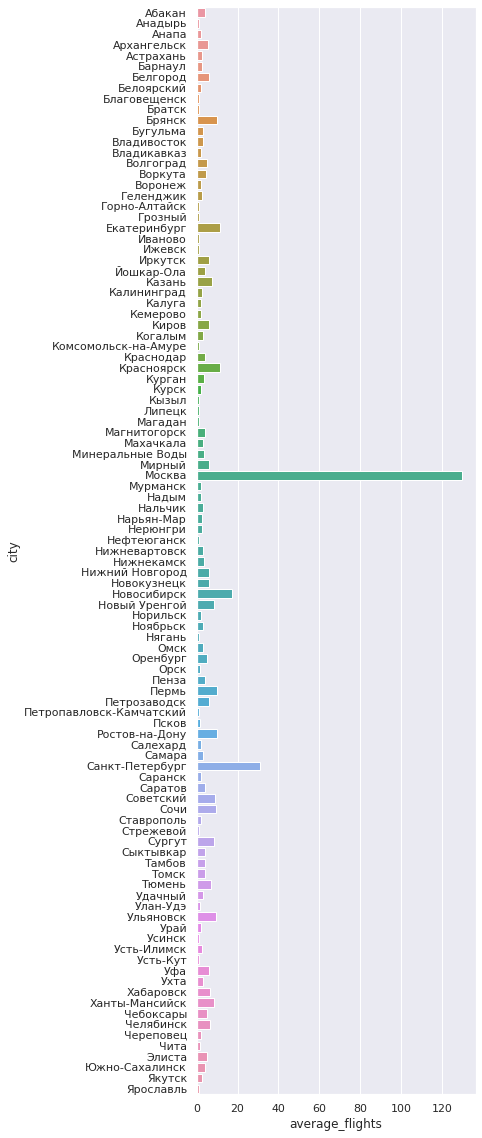

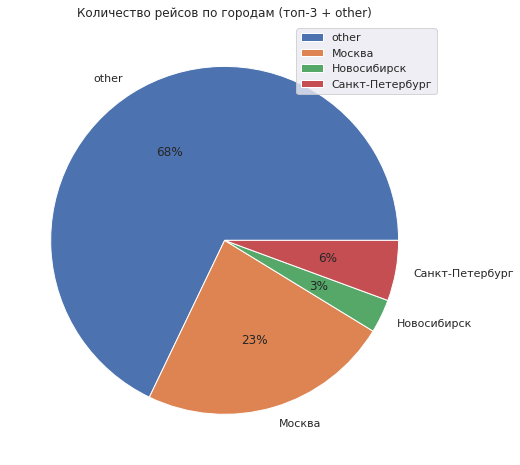

In [5]:
#график: города и количество рейсов

data_city = data_city.toPandas()
sns.set(rc={'figure.figsize':(5,20)})
sns.barplot(y=data_city['city'], x = data_city['average_flights'])
plt.show()

#доп график топ-3 и омстальные города

def top_3(x):
    if x== 'Москва':
        return 'Москва'
    if x== 'Санкт-Петербург':
        return 'Санкт-Петербург'
    if x== 'Новосибирск':
        return 'Новосибирск'
    else:
        return 'other'
    
data_city['city_new'] = data_city['city'].apply(lambda x: top_3(x)) 
data_city = data_city.drop(['city'], axis = 1)
data_city_2 = data_city.groupby('city_new').agg({'average_flights':'sum'})
data_city_2.plot(kind='pie', subplots=True, figsize=(8, 8), autopct='%1.f%%')
plt.title("Количество рейсов по городам (топ-3 + other)")
plt.ylabel("")
plt.show()

+-------------------+--------------+
|              model|flights_amount|
+-------------------+--------------+
|    Airbus A319-100|           607|
|    Airbus A321-200|           960|
|     Boeing 737-300|           630|
|     Boeing 767-300|           600|
|     Boeing 777-300|           300|
| Bombardier CRJ-200|          4446|
| Cessna 208 Caravan|          4557|
|Sukhoi SuperJet-100|          4185|
+-------------------+--------------+



None

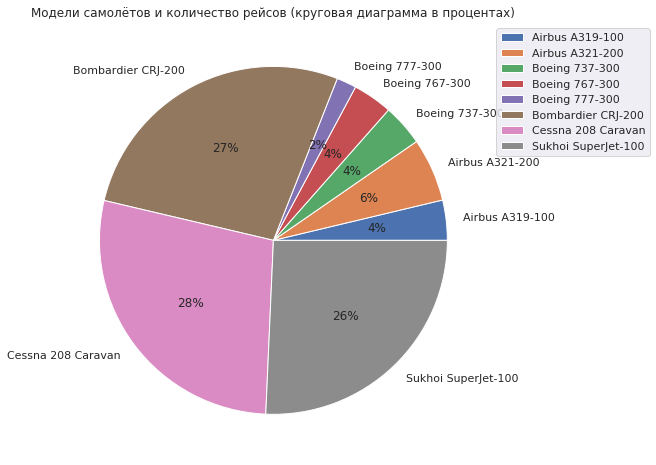

In [6]:
#график: модели самолётов и количество рейсов

display(data_model.show())

data_model = data_model.toPandas()
data_model = data_model.set_index('model')
data_model.plot(kind='pie', subplots=True, figsize=(8, 8), autopct='%1.f%%')
plt.title("Модели самолётов и количество рейсов (круговая диаграмма в процентах)")
plt.ylabel("")
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()


### Вывод:
Я загрузила 2 таблицы за сентябрь 2018: первая содержала инфомацию о модели самолета и количестве рейсов (8 моделей); и вторая - город и среднее количество прибывающих рейсов за день (101 город). Типы данных были корректны, пустые строки отсутствовали, поэтому я сразу преступила к анализу. Я выделила топ-10 городов по количеству рейсов. На первом месте оказалась Москва со средним количеством пребывающих рейсов в день - 129. Для сравнения на втором месте Санкт-Петербург с 31 рейсом. Москве принадлежат 52% рейсов среди топ-10 и 24% среди всех городов, столицы является абсолютным лидером по перелетам. В среднем в малые города за день пибывает до 5 рейсов. Также хочется отметить, что наиболее часто используемые модели самолетов это Bombardier CRJ-200 (27%) перелетов, Cessna 208 Caravan (28%) и Sukhoi SuperJet-100 (26%). На эти три модели приходится 80% перелетов.